In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error

In [2]:
# this is our target
y_CME3MSOFR = pd.read_csv(f"../data/CME3MSOFR.csv")
y_CME3MSOFR = y_CME3MSOFR.dropna(axis="columns")
y_CME3MSOFR.drop(columns=["dd", "mm", "yyyy"], inplace=True)
y_CME3MSOFR.columns = ["date", "y_rate_CME3MSOFR"]
y_CME3MSOFR["date"] = pd.to_datetime(y_CME3MSOFR["date"])
# flip it so that first row
y_CME3MSOFR = y_CME3MSOFR.iloc[::-1]
y_CME3MSOFR.reset_index(inplace=True)
y_CME3MSOFR = y_CME3MSOFR.drop(columns=["index"])
print(y_CME3MSOFR.head())

        date  y_rate_CME3MSOFR
0 2019-01-03            2.4328
1 2019-01-04            2.4296
2 2019-01-07            2.4276
3 2019-01-08            2.4298
4 2019-01-09            2.4390


In [3]:
# check NA
print(y_CME3MSOFR[y_CME3MSOFR.isna().any(axis=1)])
# describe the data
print(y_CME3MSOFR.describe())

Empty DataFrame
Columns: [date, y_rate_CME3MSOFR]
Index: []
       y_rate_CME3MSOFR
count       1199.000000
mean           1.821782
std            1.884534
min            0.016000
25%            0.069150
50%            1.579000
75%            2.665290
max            5.422450


In [4]:
# this is our feature
# 3MSOFRFuture
x_3MSOFRFuture = pd.read_csv(f"../data/3MSOFRFuture.csv")
x_3MSOFRFuture = x_3MSOFRFuture.dropna(axis="columns")
x_3MSOFRFuture.drop(columns=["dd", "mm", "yyyy"], inplace=True)
x_3MSOFRFuture.columns = ["date", "x_price_3MSOFRFuture"]
x_3MSOFRFuture["date"] = pd.to_datetime(x_3MSOFRFuture["date"])
# flip it so that first row
x_3MSOFRFuture = x_3MSOFRFuture.iloc[::-1]
x_3MSOFRFuture.reset_index(inplace=True)
x_3MSOFRFuture = x_3MSOFRFuture.drop(columns=["index"])
print(x_3MSOFRFuture.head())

        date  x_price_3MSOFRFuture
0 2018-12-14                97.370
1 2018-12-17                97.405
2 2018-12-18                97.455
3 2018-12-19                97.460
4 2018-12-20                97.470


In [5]:
# check NA
print(x_3MSOFRFuture[x_3MSOFRFuture.isna().any(axis=1)])
# describe the data
print(x_3MSOFRFuture.describe())

Empty DataFrame
Columns: [date, x_price_3MSOFRFuture]
Index: []
       x_price_3MSOFRFuture
count           1247.000000
mean              97.822650
std                1.834714
min               94.305000
25%               96.332500
50%               98.515000
75%               99.380000
max               99.990000


In [6]:
# this is our feature
# USTbill3M
x_USTbill3M = pd.read_csv(f"../data/USTbill3M.csv")
x_USTbill3M = x_USTbill3M.dropna(axis="columns")
x_USTbill3M.columns = ["date", "x_rate_USTbill3M"]
x_USTbill3M["date"] = pd.to_datetime(x_USTbill3M["date"])
# no need flip, already in correct order
print(x_USTbill3M.head())

        date  x_rate_USTbill3M
0 2018-11-26            2.3775
1 2018-11-27            2.3771
2 2018-11-28            2.3704
3 2018-11-29            2.3616
4 2018-11-30            2.3654


In [7]:
# check NA
print(x_USTbill3M[x_USTbill3M.isna().any(axis=1)])
# describe the data
print(x_USTbill3M.describe())

Empty DataFrame
Columns: [date, x_rate_USTbill3M]
Index: []
       x_rate_USTbill3M
count       1250.000000
mean           1.866989
std            1.902441
min           -0.031200
25%            0.090225
50%            1.556850
75%            2.700375
max            5.491500


In [8]:
# USD3MOIS this is weird data
x_USD3MOIS = pd.read_csv(f"../data/USD3MOIS.csv")
x_USD3MOIS.columns = ["date", "bid", "ask"]
x_USD3MOIS["date"] = pd.to_datetime(x_USD3MOIS["date"])
x_USD3MOIS["x_mid_USD3MOIS"] = 0.5 * (x_USD3MOIS["bid"] + x_USD3MOIS["ask"])
# flip it so that first row
x_USD3MOIS = x_USD3MOIS.iloc[::-1]
x_USD3MOIS = x_USD3MOIS.drop(columns=["bid", "ask"])
print(x_USD3MOIS.head())

           date  x_mid_USD3MOIS
1515 2018-01-02           1.439
1514 2018-01-03           1.444
1513 2018-01-04           1.454
1512 2018-01-05           1.454
1511 2018-01-08           1.457


In [9]:
to_concat = [x_3MSOFRFuture, x_USTbill3M, x_USD3MOIS]
df_concat = y_CME3MSOFR

In [10]:
for frames in to_concat:
    df_concat = pd.merge(df_concat, frames, on="date", how="left")
print(df_concat.describe())
print(df_concat.isna().sum())

       y_rate_CME3MSOFR  x_price_3MSOFRFuture  x_rate_USTbill3M  \
count       1199.000000           1199.000000       1198.000000   
mean           1.821782             97.893874          1.781852   
std            1.884534              1.801295          1.868201   
min            0.016000             94.305000         -0.031200   
25%            0.069150             96.635000          0.087600   
50%            1.579000             98.550000          1.541100   
75%            2.665290             99.392500          2.506525   
max            5.422450             99.990000          5.470100   

       x_mid_USD3MOIS  
count     1199.000000  
mean         1.831487  
std          1.884902  
min          0.043000  
25%          0.081000  
50%          1.556000  
75%          2.740500  
max          5.442400  
date                    0
y_rate_CME3MSOFR        0
x_price_3MSOFRFuture    0
x_rate_USTbill3M        1
x_mid_USD3MOIS          0
dtype: int64


In [11]:
df_concat = df_concat.fillna(method="bfill")
print(df_concat.isna().sum())

date                    0
y_rate_CME3MSOFR        0
x_price_3MSOFRFuture    0
x_rate_USTbill3M        0
x_mid_USD3MOIS          0
dtype: int64


In [12]:
df_concat.set_index("date", inplace=True)

In [13]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1199 entries, 2019-01-03 to 2023-11-21
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   y_rate_CME3MSOFR      1199 non-null   float64
 1   x_price_3MSOFRFuture  1199 non-null   float64
 2   x_rate_USTbill3M      1199 non-null   float64
 3   x_mid_USD3MOIS        1199 non-null   float64
dtypes: float64(4)
memory usage: 46.8 KB


In [14]:
# df_concat.index = pd.to_datetime(df_concat.index)
# train = df_concat.loc[df_concat.index < pd.to_datetime("2023-01-01")]
# test = df_concat.loc[df_concat.index >= pd.to_datetime("2023-01-01")]

# fig, ax = plt.subplots()
# train["y_rate_CME3MSOFR"].plot(
#    ax=ax, label="Training Set", title="Data Train/Test Split : y_rate_CME3MSOFR"
# )
# test["y_rate_CME3MSOFR"].plot(ax=ax, label="Test Set")
# ax.axvline(pd.to_datetime("2023-01-01"), color="black", ls="--")
# plt.show()

In [15]:
#  df_concat = create_features(df_concat)
df_concat.head()

,y_rate_CME3MSOFR,x_price_3MSOFRFuture,x_rate_USTbill3M,x_mid_USD3MOIS
date,,,,
2019-01-03,2.4328,97.835,2.3919,2.393
2019-01-04,2.4296,97.770,2.4058,2.404
2019-01-07,2.4276,97.725,2.4127,2.407
2019-01-08,2.4298,97.655,2.4243,2.415
2019-01-09,2.4390,97.665,2.4213,2.410


## Feature Lagging ##

In [16]:
to_shift = [
    "x_price_3MSOFRFuture",
    "x_rate_USTbill3M",
    "x_mid_USD3MOIS",
]
lookback = 3  # start lag from and go backwards

In [17]:
def make_lags(ts, lags):
    return pd.concat(
        {f"y_lag_{i}": ts.shift(i) for i in range(lookback, lookback + lags + 1)},
        axis=1,
    )


# Create three lags for each feature term
X0 = make_lags(df_concat[to_shift], lags=3)
X0.columns = [" ".join(col).strip() for col in X0.columns.values]

X0 = X0.fillna(method="bfill")

In [18]:
X0.head()

,y_lag_3 x_price_3MSOFRFuture,y_lag_3 x_rate_USTbill3M,y_lag_3 x_mid_USD3MOIS,y_lag_4 x_price_3MSOFRFuture,y_lag_4 x_rate_USTbill3M,y_lag_4 x_mid_USD3MOIS,y_lag_5 x_price_3MSOFRFuture,y_lag_5 x_rate_USTbill3M,y_lag_5 x_mid_USD3MOIS,y_lag_6 x_price_3MSOFRFuture,y_lag_6 x_rate_USTbill3M,y_lag_6 x_mid_USD3MOIS
date,,,,,,,,,,,,
2019-01-03,97.835,2.3919,2.393,97.835,2.3919,2.393,97.835,2.3919,2.393,97.835,2.3919,2.393
2019-01-04,97.835,2.3919,2.393,97.835,2.3919,2.393,97.835,2.3919,2.393,97.835,2.3919,2.393
2019-01-07,97.835,2.3919,2.393,97.835,2.3919,2.393,97.835,2.3919,2.393,97.835,2.3919,2.393
2019-01-08,97.835,2.3919,2.393,97.835,2.3919,2.393,97.835,2.3919,2.393,97.835,2.3919,2.393
2019-01-09,97.770,2.4058,2.404,97.835,2.3919,2.393,97.835,2.3919,2.393,97.835,2.3919,2.393


In [19]:
# Create four lags for the target, as before
X1 = make_lags(df_concat["y_rate_CME3MSOFR"], lags=3)

In [20]:
# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(method="bfill")

In [21]:
y = y_CME3MSOFR.y_rate_CME3MSOFR.copy()

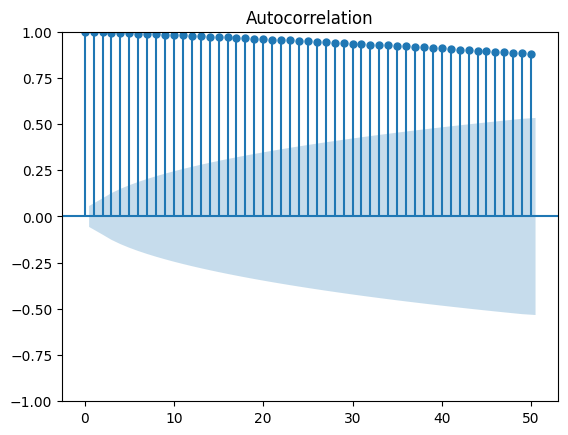

In [22]:
_ = plot_acf(y_CME3MSOFR.y_rate_CME3MSOFR, lags=50)

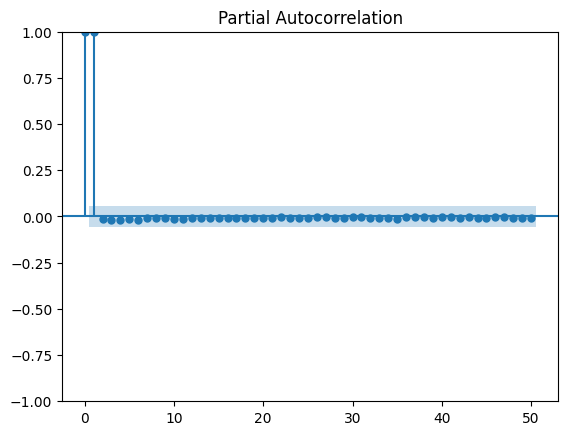

In [23]:
_ = plot_pacf(y_CME3MSOFR.y_rate_CME3MSOFR, lags=50)

## LINEAR REGRESSION ONLY ##

In [24]:
my_test_size = 300

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=my_test_size, shuffle=False
)

model = LinearRegression()
model.fit(X_train, y_train)
y_fit = pd.Series(
    model.predict(X_train), index=y_train.index
)  # y from predicting using X_train
y_pred = pd.Series(
    model.predict(X_test), index=y_test.index
)  #  y from predicting using X_test

In [26]:
y_cut = pd.Series(y, index=y_test.index).dropna()

In [27]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)

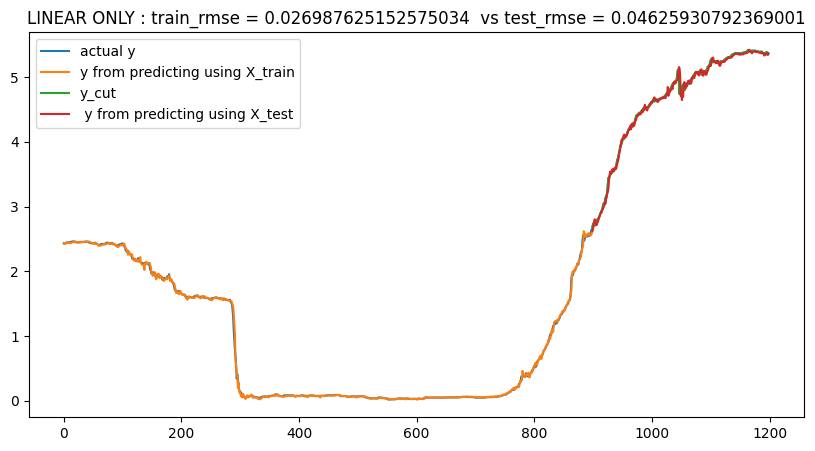

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(y, label="actual y")
plt.plot(y_fit, label="y from predicting using X_train")
plt.plot(y_cut, label="y_cut")
plt.plot(y_pred, label=" y from predicting using X_test")
plt.title(f"LINEAR ONLY : train_rmse = {train_rmse}  vs test_rmse = {test_rmse}")
plt.legend()

## Incorporate XGBOOST ##

1. Train and predict with first model
```
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)
```
2. Train and predict with second model on residuals
```
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)
```
3. Add to get overall predictions
```
y_pred = y_pred_1 + y_pred_2
```

In [29]:
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=my_test_size, shuffle=False
)

model = LinearRegression()
model.fit(X_train, y_train)
y_fit = pd.Series(
    model.predict(X_train), index=y_train.index
)  # y from predicting using X_train
y_pred = pd.Series(
    model.predict(X_test), index=y_test.index
)  #  y from predicting using X_test

# create target residuals
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb_reg = xgb.XGBRegressor(n_estimators=10000)
xgb_reg.fit(X_train, y_resid)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [30]:
# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb_reg.predict(X_train) + y_fit
y_pred_boosted = xgb_reg.predict(X_test) + y_pred

In [31]:
train_rmse = mean_squared_error(y_train, y_fit_boosted, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_boosted, squared=False)

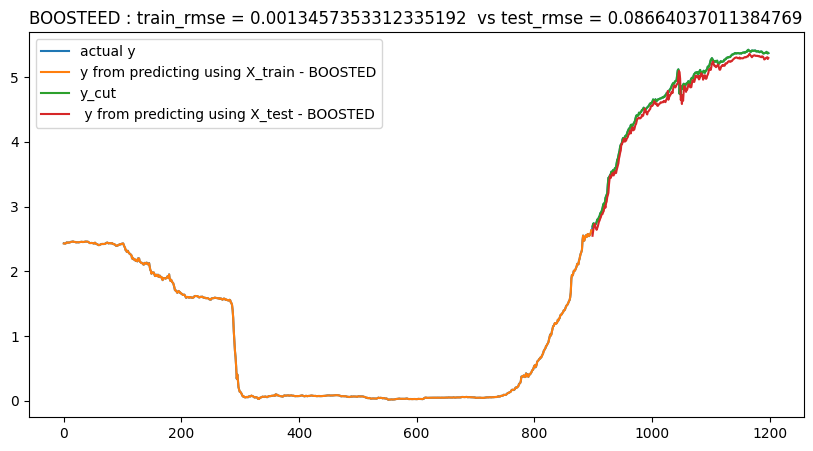

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(y, label="actual y")
plt.plot(y_fit_boosted, label="y from predicting using X_train - BOOSTED")
plt.plot(y_cut, label="y_cut")
plt.plot(y_pred_boosted, label=" y from predicting using X_test - BOOSTED")
plt.title(f"BOOSTEED : train_rmse = {train_rmse}  vs test_rmse = {test_rmse}")
plt.legend()